# Demo

Contents:

1. Layer-wise Relevance Propagation (LRP)
1. Quantitative evaluation of LRP explanation using Region Perturbation (perturbation modes: inpainting, random)

## LRP

Files already downloaded and verified
Finished 'relevance' in 8.4327 secs


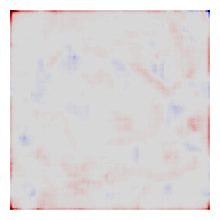

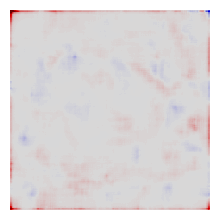

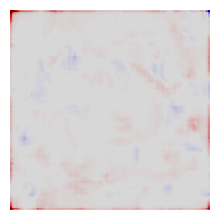

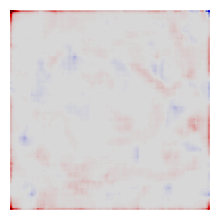

In [30]:
from typing import Callable, Dict, List, Tuple, Union

import numpy
import torch
import torchvision
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import lrp.plot
from lrp import image, rules
from lrp.core import LRP
from lrp.filter import LayerFilter
from lrp.rules import LrpEpsilonRule, LrpGammaRule, LrpZBoxRule, LrpZeroRule
from lrp.zennit.types import AvgPool, Linear

from datasets import load_dataset

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for VGG16
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)



# Input data
# Image is in RGB mode with range [0,1]
# img_bgr_hwc_float_0_1: numpy.array = image.load_img_norm_zero_one('data/castle.jpg')
# X = lrp.norm.ImageNetNorm.transform(img_bgr_hwc_float_0_1)

# Simulate batch by adding a new dimension so that X is in NCHW format
# N is the batch size
# C is the number of channels
# H is the height
# W is the width
# X = torch.unsqueeze(X, 0)

# Hide plot axes
# plt.axis('off')

# Plot input image
# lrp.plot.plot_imagenet(X)

# Model
# Modify VGG16 for CIFAR-10
model = torchvision.models.vgg16(pretrained=True)
model.classifier[6] = torch.nn.Linear(4096, 10)  # Adjust the classifier for 10 CIFAR-10 classes
model.eval()

# Global dictionary to store activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks as before
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
        layer.register_forward_hook(get_activation(name))
        
def get_class_loader(dataset, class_index, batch_size=4):
    # Filter dataset for a specific class
    class_data = [data for data in dataset if data[1] == class_index]
    
    # Create a DataLoader for the class-specific dataset
    class_loader = torch.utils.data.DataLoader(class_data, batch_size=batch_size, shuffle=True)
    return class_loader

# Choose a class index (e.g., 3 for 'Cat' in CIFAR-10)
class_index = 3

# Get DataLoader for the specific class
class_loader = get_class_loader(trainset, class_index)

# Clear previous activations
activations.clear()

# Process a batch of images from the specific class
class_images, class_labels = next(iter(class_loader))
output = model(class_images)

# At this point, 'activations' will contain the activations for the specific class



# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

# Init layer filter
target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type: LayerFilter = LayerFilter(model=model,
                                                      target_types=target_types)

name_map: List[Tuple[List[str], rules.LrpRule,
                     Dict[str, Union[torch.Tensor, float]]]]

# LRP Composite from Montavon's lrp-tutorial
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

# Init LRP
lrp_instance: LRP = LRP(model)

# Prepare model layers for LRP
lrp_instance.convert_layers(name_map)

# Compute relevance attributions
# R: torch.Tensor = lrp_instance.relevance(X)

# Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Forward pass to trigger hooks and get output (for printing activation values)
output = model(images)

# Compute relevance attributions for CIFAR-10 images
R = lrp_instance.relevance(images)


# Display heatmap
lrp_instance.heatmap(R, width=2, height=2)

In [17]:
pip install tqdm


Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.5/388.5 kB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.3/330.3 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
Note: you may need to restart the kernel to use updated packages.


In [17]:
from datasets import load_dataset

# Specify the configuration name (choose from 'r-10', 'r-20', 'r-50', 'r-100', 'r-200')
config_name = 'r-10'  # for example

# Load the CIFAR-10-LT dataset with the specified configuration
dataset = load_dataset("tomas-gajarsky/cifar10-lt", config_name)

# Split the dataset into training and test sets
train_dataset = dataset['train']
test_dataset = dataset['test']

# Explore the dataset structure
print(train_dataset)
print(test_dataset)


Dataset({
    features: ['img', 'label'],
    num_rows: 4084
})
Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


In [6]:
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from PIL import Image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image for VGG16
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (values for ImageNet)
])

# Function to transform the dataset
def transform_dataset(dataset):
    images = []
    labels = []
    for item in dataset:
        image = item['img']
        
        # Check if the image is not a PIL Image
        if not isinstance(image, Image.Image):
            if isinstance(image, torch.Tensor):
                # If it's a tensor, move it to CPU and convert to numpy
                image = image.cpu().numpy()
            image = Image.fromarray(image)  # Convert numpy array to PIL Image
        
        image = transform(image)  # Apply transformations
        images.append(image)
        labels.append(item['label'])
    
    # Convert lists to tensors
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return TensorDataset(images, labels)

# Transform the training dataset
train_dataset = transform_dataset(train_dataset)
test_dataset = transform_dataset(test_dataset)

# Explore the transformed dataset
print(train_dataset)
print(test_dataset)



In [19]:
# Define batch size
batch_size = 32

# Create the DataLoader for training data
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the DataLoader
for images, labels in trainloader:
    print(images.shape)  # Should be [batch_size, 3, 224, 224]
    print(labels.shape)  # Should be [batch_size]
    break


torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
# Step 3: Compile the Model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


from tqdm import tqdm

num_epochs = 10  # Set the number of epochs

# Step 4: Train the Model
for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f'Epoch {epoch + 1}/{num_epochs}')
    for i, data in progress_bar:
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Update progress bar
        progress_bar.set_postfix(loss=(running_loss / (i + 1)))

    # Print at the end of each epoch
    average_loss = running_loss / len(trainloader)
    print(f'End of Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss:.3f}')

print('Finished Training')

# Step 5: Evaluate the Model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# Define a path for saving the model
model_save_path = 'vgg16_cifar10_lt_full_model.pth'

torch.save(model, model_save_path)

# Using LRP
# Compute and display LRP heatmaps for some test images to interpret the model's predictions
# ...


Epoch 1/10:   7%|▋         | 9/128 [01:45<23:20, 11.77s/it, loss=2.27]

Finished 'relevance' in 8.2161 secs


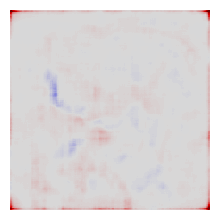

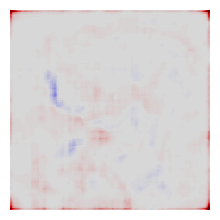

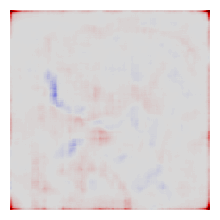

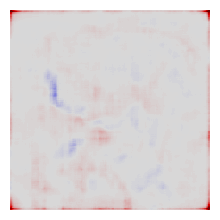

In [7]:
# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

# Init layer filter
target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type: LayerFilter = LayerFilter(model=model,
                                                      target_types=target_types)

name_map: List[Tuple[List[str], rules.LrpRule,
                     Dict[str, Union[torch.Tensor, float]]]]

# LRP Composite from Montavon's lrp-tutorial
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

# Init LRP
lrp_instance: LRP = LRP(model)

# Prepare model layers for LRP
lrp_instance.convert_layers(name_map)

# Compute relevance attributions
# R: torch.Tensor = lrp_instance.relevance(X)

# Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Forward pass to trigger hooks and get output (for printing activation values)
output = model(images)

# Compute relevance attributions for CIFAR-10 images
R = lrp_instance.relevance(images)


# Display heatmap
lrp_instance.heatmap(R, width=2, height=2)

In [8]:
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
        print(f"Registering hook for layer: {name}")
        layer.register_forward_hook(get_activation(name))


Registering hook for layer: features.0
Registering hook for layer: features.2
Registering hook for layer: features.5
Registering hook for layer: features.7
Registering hook for layer: features.10
Registering hook for layer: features.12
Registering hook for layer: features.14
Registering hook for layer: features.17
Registering hook for layer: features.19
Registering hook for layer: features.21
Registering hook for layer: features.24
Registering hook for layer: features.26
Registering hook for layer: features.28
Registering hook for layer: classifier.0
Registering hook for layer: classifier.3
Registering hook for layer: classifier.6


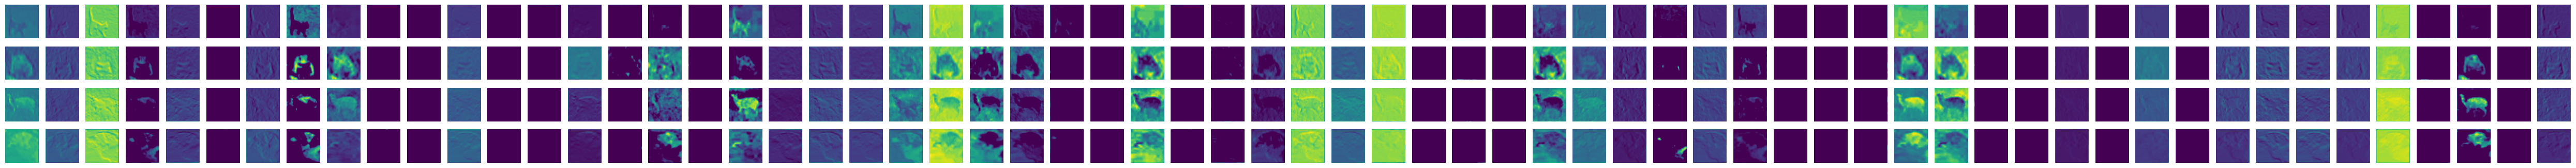

In [9]:
import matplotlib.pyplot as plt

def plot_activations_for_layer(layer_activations):
    # Assuming layer_activations shape is [batch_size, num_filters, height, width]
    batch_size, num_filters, _, _ = layer_activations.shape
    
    fig, axes = plt.subplots(batch_size, num_filters, figsize=(num_filters, batch_size))
    
    for i in range(batch_size):
        for j in range(num_filters):
            ax = axes[i, j]
            ax.imshow(layer_activations[i, j].cpu().numpy(), cmap='viridis')
            ax.axis('off')
    
    plt.show()

# Example: Plot activations for the first conv layer
# Replace 'first_conv_layer_name' with the actual name of the first conv layer in your model
plot_activations_for_layer(activations['features.0'])


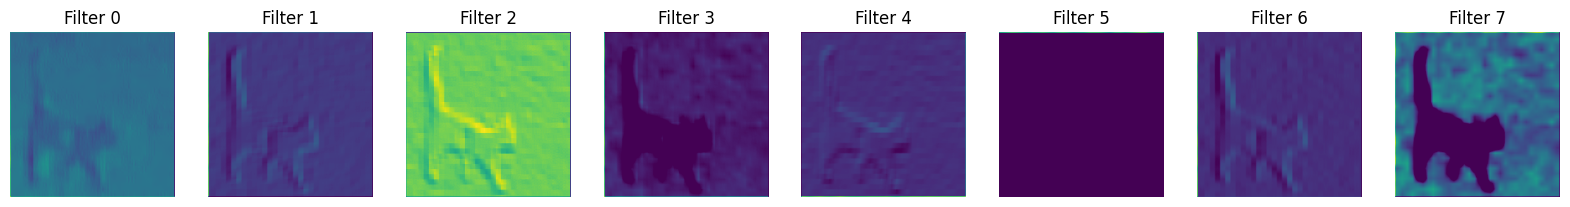

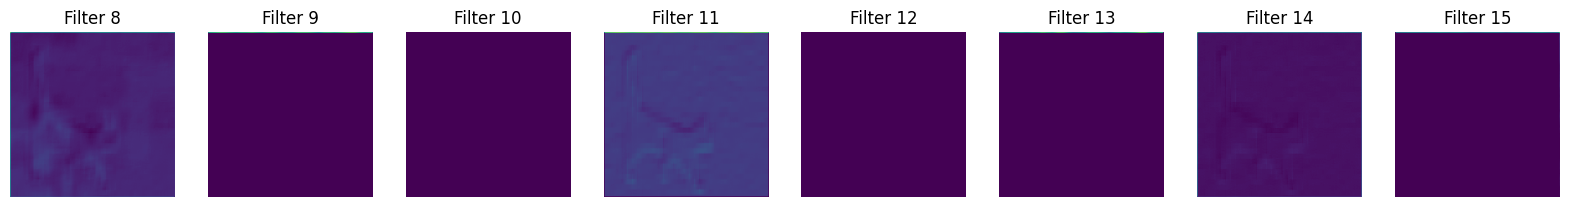

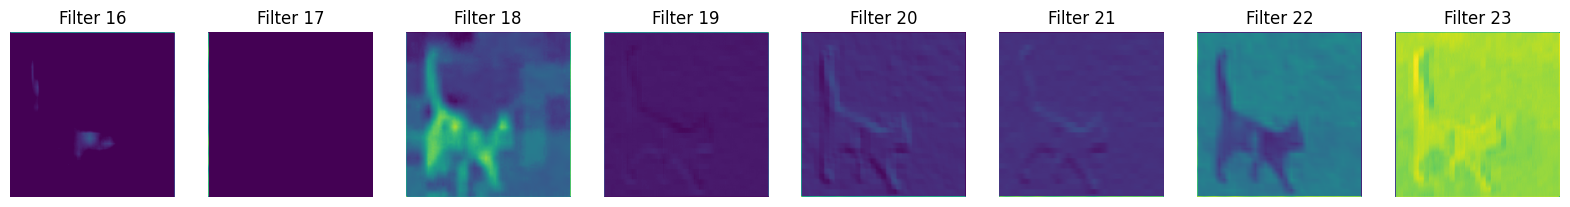

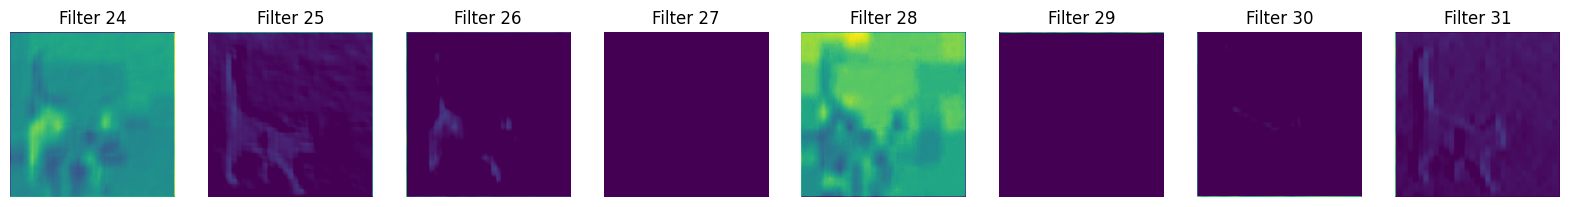

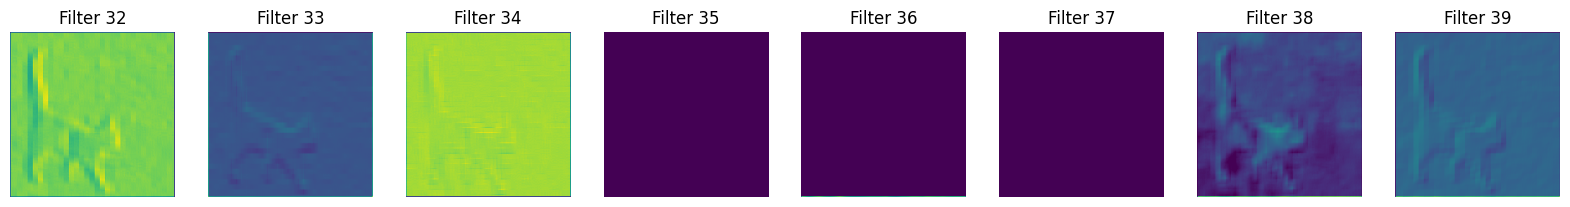

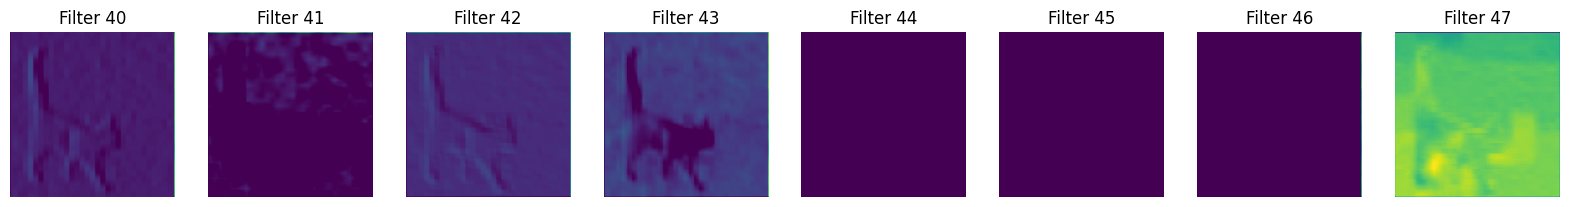

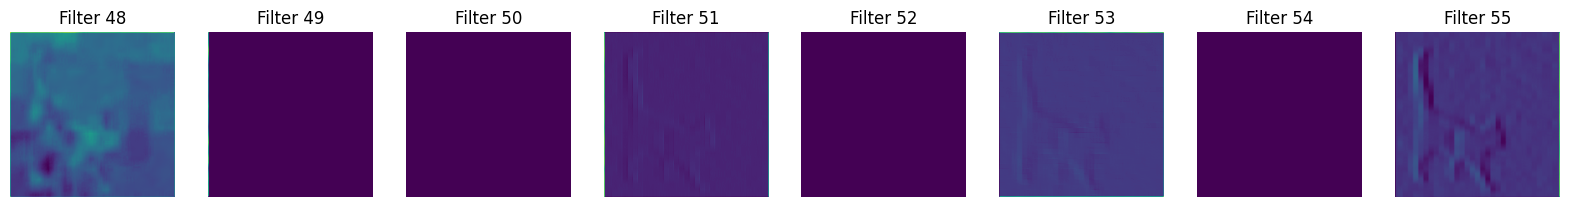

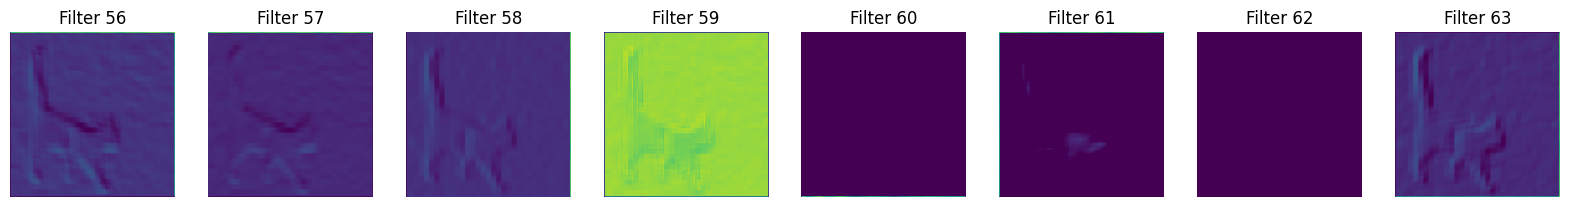

In [10]:
import matplotlib.pyplot as plt

def plot_activations_for_subset_of_filters(layer_activations, num_images=1, filters_per_fig=16):
    # Assuming layer_activations shape is [batch_size, num_filters, height, width]
    _, num_filters, _, _ = layer_activations.shape
    
    # Limit the number of images
    num_images = min(layer_activations.shape[0], num_images)
    
    # Iterate over filters in sets
    for start_filter in range(0, num_filters, filters_per_fig):
        end_filter = min(start_filter + filters_per_fig, num_filters)
        fig, axes = plt.subplots(num_images, end_filter - start_filter, figsize=(20, 10))

        for i in range(num_images):
            for j, filter_idx in enumerate(range(start_filter, end_filter)):
                ax = axes[i, j] if num_images > 1 else axes[j]
                ax.imshow(layer_activations[i, filter_idx].cpu().numpy(), cmap='viridis')
                ax.axis('off')
                ax.set_title(f'Filter {filter_idx}')

        plt.show()

# Example: Plot activations for the first conv layer for 5 images
plot_activations_for_subset_of_filters(activations['features.0'], num_images=1, filters_per_fig=8)


In [11]:
# Example: Collect activations for two classes
class_indices = [3, 5]  # Example class indices

class_activations = {}
for class_index in class_indices:
    class_loader = get_class_loader(trainset, class_index)
    class_images, _ = next(iter(class_loader))
    output = model(class_images)

    class_activations[class_index] = dict(activations)

# Now class_activations contains activations for each class in one batch
# You can compare these, e.g., by computing and comparing statistics


In [12]:
# Function to compute various statistics of activations
def compute_activation_statistics(activation_dict):
    stats = {}
    for layer, activation in activation_dict.items():
        stats[layer] = {
            'mean': activation.mean().item(),
            'std': activation.std().item(),
            'median': activation.median().item(),
            'min': activation.min().item(),
            'max': activation.max().item(),
            'range': activation.max().item() - activation.min().item()
        }
    return stats

# Dictionary to store statistics for each class
class_stats = {}

# Assuming 'class_activations' is a dictionary with class indices as keys
# and activations (from different layers) as values

# Compute statistics for each class
for class_index, activations in class_activations.items():
    class_stats[class_index] = compute_activation_statistics(activations)

# Print all statistical values for each class and layer
for layer in class_stats[class_indices[0]].keys():
    print(f"Layer: {layer}")
    for class_index in class_indices:
        stats = class_stats[class_index][layer]
        print(f"Class {class_index}:")
        print(f"  Mean: {stats['mean']}")
        print(f"  Standard Deviation: {stats['std']}")
        print(f"  Median: {stats['median']}")
        print(f"  Min: {stats['min']}")
        print(f"  Max: {stats['max']}")
        print(f"  Range: {stats['range']}")
        print()


Layer: features.0
Class 3:
  Mean: 0.1839117705821991
  Standard Deviation: 0.20927967131137848
  Median: 0.10063983500003815
  Min: 0.0
  Max: 5.213346481323242
  Range: 5.213346481323242

Class 5:
  Mean: 0.1848103106021881
  Standard Deviation: 0.21367767453193665
  Median: 0.09298063814640045
  Min: 0.0
  Max: 5.280171871185303
  Range: 5.280171871185303

Layer: features.2
Class 3:
  Mean: 0.1643342822790146
  Standard Deviation: 0.3157849609851837
  Median: 0.0
  Min: 0.0
  Max: 7.845876216888428
  Range: 7.845876216888428

Class 5:
  Mean: 0.1714746356010437
  Standard Deviation: 0.3298637270927429
  Median: 0.0
  Min: 0.0
  Max: 8.037537574768066
  Range: 8.037537574768066

Layer: features.5
Class 3:
  Mean: 0.3283044099807739
  Standard Deviation: 0.39996951818466187
  Median: 0.1772758811712265
  Min: 0.0
  Max: 9.06768798828125
  Range: 9.06768798828125

Class 5:
  Mean: 0.33406540751457214
  Standard Deviation: 0.4044366180896759
  Median: 0.18579493463039398
  Min: 0.0
  Ma

In [14]:
pip install xlsxwriter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.3 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd

# Assuming 'activations' is a dictionary with layer names as keys and 4D-tensors as values
# For example, each activation could be of shape [batch_size, channels, height, width]

with pd.ExcelWriter('activations.xlsx', engine='xlsxwriter') as writer:
    for layer_name, activation in activations.items():
        print(f"Layer: {layer_name}, Activation Shape: {activation.shape}")

        # Iterate over each 2D activation map in the tensor
        for channel in range(activation.shape[1]):  # Iterating over channels
            for batch in range(activation.shape[0]):  # Iterating over batches if necessary
                # Extract the 2D activation map
                activation_2d = activation[batch, channel, :, :]

                # Convert to a DataFrame
                df = pd.DataFrame(activation_2d.numpy())

                # Define a unique sheet name for each 2D activation map
                sheet_name = f"{layer_name}_Batch{batch}_Channel{channel}"

                # Write to the Excel file
                df.to_excel(writer, sheet_name=sheet_name, index=False)


Layer: features.0, Activation Shape: torch.Size([4, 64, 224, 224])
Layer: features.2, Activation Shape: torch.Size([4, 64, 224, 224])
Layer: features.5, Activation Shape: torch.Size([4, 128, 112, 112])
Layer: features.7, Activation Shape: torch.Size([4, 128, 112, 112])
Layer: features.10, Activation Shape: torch.Size([4, 256, 56, 56])
Layer: features.12, Activation Shape: torch.Size([4, 256, 56, 56])
Layer: features.14, Activation Shape: torch.Size([4, 256, 56, 56])
Layer: features.17, Activation Shape: torch.Size([4, 512, 28, 28])
Layer: features.19, Activation Shape: torch.Size([4, 512, 28, 28])
Layer: features.21, Activation Shape: torch.Size([4, 512, 28, 28])
Layer: features.24, Activation Shape: torch.Size([4, 512, 14, 14])
Layer: features.26, Activation Shape: torch.Size([4, 512, 14, 14])
Layer: features.28, Activation Shape: torch.Size([4, 512, 14, 14])
Layer: classifier.0, Activation Shape: torch.Size([4, 4096])


IndexError: too many indices for tensor of dimension 2

In [16]:
import pandas as pd

with pd.ExcelWriter('activations_2.xlsx', engine='xlsxwriter') as writer:
    for layer_name, activation in activations.items():
        print(f"Layer: {layer_name}, Activation Shape: {activation.shape}")

        # Check the number of dimensions of the tensor
        if activation.dim() == 4:  # 4D Tensor
            for channel in range(activation.shape[1]):
                for batch in range(activation.shape[0]):
                    activation_2d = activation[batch, channel, :, :]
                    df = pd.DataFrame(activation_2d.numpy())
                    sheet_name = f"{layer_name}_Batch{batch}_Channel{channel}"
                    df.to_excel(writer, sheet_name=sheet_name, index=False)
        elif activation.dim() == 2:  # 2D Tensor
            df = pd.DataFrame(activation.numpy())
            sheet_name = f"{layer_name}"
            df.to_excel(writer, sheet_name=sheet_name, index=False)
        else:
            print(f"Unsupported tensor shape for layer {layer_name}")


Layer: features.0, Activation Shape: torch.Size([4, 64, 224, 224])
Layer: features.2, Activation Shape: torch.Size([4, 64, 224, 224])
Layer: features.5, Activation Shape: torch.Size([4, 128, 112, 112])
Layer: features.7, Activation Shape: torch.Size([4, 128, 112, 112])
Layer: features.10, Activation Shape: torch.Size([4, 256, 56, 56])
Layer: features.12, Activation Shape: torch.Size([4, 256, 56, 56])
Layer: features.14, Activation Shape: torch.Size([4, 256, 56, 56])
Layer: features.17, Activation Shape: torch.Size([4, 512, 28, 28])
Layer: features.19, Activation Shape: torch.Size([4, 512, 28, 28])
Layer: features.21, Activation Shape: torch.Size([4, 512, 28, 28])
Layer: features.24, Activation Shape: torch.Size([4, 512, 14, 14])
Layer: features.26, Activation Shape: torch.Size([4, 512, 14, 14])
Layer: features.28, Activation Shape: torch.Size([4, 512, 14, 14])
Layer: classifier.0, Activation Shape: torch.Size([4, 4096])
Layer: classifier.3, Activation Shape: torch.Size([4, 4096])
Layer

In [17]:
import os
import pandas as pd

class_indices = [1, 2]  # Example class indices

class_activations = {}
for class_index in class_indices:
    class_loader = get_class_loader(trainset, class_index)
    class_images, _ = next(iter(class_loader))
    output = model(class_images)
    class_activations[class_index] = dict(activations)

# Function to compute various statistics of activations
def compute_activation_statistics(activation_dict):
    stats = {}
    for layer, activation in activation_dict.items():
        stats[layer] = {
            'mean': activation.mean().item(),
            'std': activation.std().item(),
            'median': activation.median().item(),
            'min': activation.min().item(),
            'max': activation.max().item(),
            'range': activation.max().item() - activation.min().item()
        }
    return stats

# Dictionary to store statistics for each class
class_stats = {}

# Compute statistics for each class
for class_index, activations in class_activations.items():
    class_stats[class_index] = compute_activation_statistics(activations)

# Print all statistical values for each class and layer
for layer in class_stats[class_indices[0]].keys():
    print(f"Layer: {layer}")
    for class_index in class_indices:
        stats = class_stats[class_index][layer]
        print(f"Class {class_index}:")
        print(f"  Mean: {stats['mean']}")
        print(f"  Standard Deviation: {stats['std']}")
        print(f"  Median: {stats['median']}")
        print(f"  Min: {stats['min']}")
        print(f"  Max: {stats['max']}")
        print(f"  Range: {stats['range']}")
        print()

# Create a directory for the output files
output_dir = 'activation_outputs_1_2'
os.makedirs(output_dir, exist_ok=True)

# Loop through each class activation and save to separate Excel files
for class_index, activations in class_activations.items():
    for layer_name, activation in activations.items():
        print(f"Layer: {layer_name}, Activation Shape: {activation.shape}")

        # File path for the current layer
        file_path = os.path.join(output_dir, f'class_{class_index}_{layer_name}.xlsx')

        with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
            # Check the number of dimensions of the tensor
            if activation.dim() == 4:  # 4D Tensor
                for channel in range(activation.shape[1]):
                    for batch in range(activation.shape[0]):
                        activation_2d = activation[batch, channel, :, :]
                        df = pd.DataFrame(activation_2d.numpy())
                        sheet_name = f"Batch{batch}_Channel{channel}"
                        df.to_excel(writer, sheet_name=sheet_name, index=False)
            elif activation.dim() == 2:  # 2D Tensor
                df = pd.DataFrame(activation.numpy())
                sheet_name = f"LayerData"
                df.to_excel(writer, sheet_name=sheet_name, index=False)
            else:
                print(f"Unsupported tensor shape for layer {layer_name}")

Layer: features.0
Class 1:
  Mean: 0.18857991695404053
  Standard Deviation: 0.2186894565820694
  Median: 0.11935077607631683
  Min: 0.0
  Max: 5.280171871185303
  Range: 5.280171871185303

Class 2:
  Mean: 0.19238853454589844
  Standard Deviation: 0.21237817406654358
  Median: 0.13284601271152496
  Min: 0.0
  Max: 4.58171272277832
  Range: 4.58171272277832

Layer: features.2
Class 1:
  Mean: 0.17068737745285034
  Standard Deviation: 0.3377985656261444
  Median: 0.0
  Min: 0.0
  Max: 8.037537574768066
  Range: 8.037537574768066

Class 2:
  Mean: 0.16080142557621002
  Standard Deviation: 0.31199416518211365
  Median: 0.0
  Min: 0.0
  Max: 7.033193588256836
  Range: 7.033193588256836

Layer: features.5
Class 1:
  Mean: 0.3480563163757324
  Standard Deviation: 0.43505725264549255
  Median: 0.1783244013786316
  Min: 0.0
  Max: 10.650239944458008
  Range: 10.650239944458008

Class 2:
  Mean: 0.32733801007270813
  Standard Deviation: 0.3932395875453949
  Median: 0.1864146590232849
  Min: 0.0

In [37]:
import os
import pandas as pd

class_indices = [8, 9]  # Example class indices
# Create a directory for the output CSV files
output_dir = 'activation_outputs_csv_8_9'

class_activations = {}
for class_index in class_indices:
    class_loader = get_class_loader(trainset, class_index)
    class_images, _ = next(iter(class_loader))
    output = model(class_images)
    class_activations[class_index] = dict(activations)

# Function to compute various statistics of activations
def compute_activation_statistics(activation_dict):
    stats = {}
    for layer, activation in activation_dict.items():
        stats[layer] = {
            'mean': activation.mean().item(),
            'std': activation.std().item(),
            'median': activation.median().item(),
            'min': activation.min().item(),
            'max': activation.max().item(),
            'range': activation.max().item() - activation.min().item()
        }
    return stats

# Dictionary to store statistics for each class
class_stats = {}

# Compute statistics for each class
for class_index, activations in class_activations.items():
    class_stats[class_index] = compute_activation_statistics(activations)

# Print all statistical values for each class and layer
for layer in class_stats[class_indices[0]].keys():
    print(f"Layer: {layer}")
    for class_index in class_indices:
        stats = class_stats[class_index][layer]
        print(f"Class {class_index}:")
        print(f"  Mean: {stats['mean']}")
        print(f"  Standard Deviation: {stats['std']}")
        print(f"  Median: {stats['median']}")
        print(f"  Min: {stats['min']}")
        print(f"  Max: {stats['max']}")
        print(f"  Range: {stats['range']}")
        print()

os.makedirs(output_dir, exist_ok=True)

# Loop through each class activation and save to separate CSV files
for class_index, activations in class_activations.items():
    for layer_name, activation in activations.items():
        print(f"Layer: {layer_name}, Activation Shape: {activation.shape}")

        # Check the number of dimensions of the tensor
        if activation.dim() == 4:  # 4D Tensor
            for channel in range(activation.shape[1]):
                for batch in range(activation.shape[0]):
                    activation_2d = activation[batch, channel, :, :]
                    df = pd.DataFrame(activation_2d.numpy())

                    # File path for the current slice
                    file_name = f'class_{class_index}_{layer_name}_Batch{batch}_Channel{channel}.csv'
                    file_path = os.path.join(output_dir, file_name)
                    
                    # Write to CSV
                    df.to_csv(file_path, index=False)

        elif activation.dim() == 2:  # 2D Tensor
            df = pd.DataFrame(activation.numpy())

            # File path for the current layer
            file_name = f'class_{class_index}_{layer_name}.csv'
            file_path = os.path.join(output_dir, file_name)
            
            # Write to CSV
            df.to_csv(file_path, index=False)

        else:
            print(f"Unsupported tensor shape for layer {layer_name}")


Layer: features.0
Class 8:
  Mean: 0.19698207080364227
  Standard Deviation: 0.20652174949645996
  Median: 0.16590063273906708
  Min: 0.0
  Max: 3.754533529281616
  Range: 3.754533529281616

Class 9:
  Mean: 0.18899551033973694
  Standard Deviation: 0.21927422285079956
  Median: 0.11242233216762543
  Min: 0.0
  Max: 5.280171871185303
  Range: 5.280171871185303

Layer: features.2
Class 8:
  Mean: 0.1548820286989212
  Standard Deviation: 0.30798763036727905
  Median: 0.0
  Min: 0.0
  Max: 5.996183395385742
  Range: 5.996183395385742

Class 9:
  Mean: 0.17628800868988037
  Standard Deviation: 0.35911914706230164
  Median: 0.0
  Min: 0.0
  Max: 8.037537574768066
  Range: 8.037537574768066

Layer: features.5
Class 8:
  Mean: 0.31421396136283875
  Standard Deviation: 0.37126490473747253
  Median: 0.18671156466007233
  Min: 0.0
  Max: 8.030814170837402
  Range: 8.030814170837402

Class 9:
  Mean: 0.33986273407936096
  Standard Deviation: 0.41907766461372375
  Median: 0.1745692789554596
  Min:

In [10]:
import pandas as pd
for layer_name, activation in activations.items():
    print(f"Layer: {layer_name}, Activation Shape: {activation.shape}")
    print(activation)
    
# activation_2d = activation.view(-1, activation.shape[-1] * activation.shape[-2])

# # Convert to a DataFrame
# df = pd.DataFrame(activation_2d.numpy())

# # Now, save the DataFrame to an Excel file
# df.to_excel("activation_data.xlsx", index=False)

import pandas as pd

MAX_COLS = 16384

with pd.ExcelWriter('activations.xlsx', engine='xlsxwriter') as writer:
    for layer_name, activation in activations.items():
        print(f"Layer: {layer_name}, Activation Shape: {activation.shape}")
        
        # Flatten or reshape your tensor
        activation_2d = activation.view(-1, activation.shape[-1] * activation.shape[-2])
        
        # Convert to a DataFrame
        df = pd.DataFrame(activation_2d.numpy())
        
        # Write each chunk of the DataFrame to a different sheet
        for start_col in range(0, df.shape[1], MAX_COLS):
            end_col = min(start_col + MAX_COLS, df.shape[1])
            sheet_name = f'{layer_name}_Sheet{start_col // MAX_COLS + 1}'
            df.iloc[:, start_col:end_col].to_excel(writer, sheet_name=sheet_name, index=False)


#tensor values to be saved


Layer: features.0, Activation Shape: torch.Size([4, 64, 224, 224])
tensor([[[[0.7987, 0.4402, 0.4402,  ..., 0.4227, 0.4227, 0.3542],
          [0.9973, 0.4749, 0.4749,  ..., 0.4189, 0.4189, 0.3222],
          [0.9973, 0.4749, 0.4749,  ..., 0.4189, 0.4189, 0.3222],
          ...,
          [0.7000, 0.4238, 0.4238,  ..., 0.4809, 0.4809, 0.0365],
          [0.7000, 0.4238, 0.4238,  ..., 0.4809, 0.4809, 0.0365],
          [0.7399, 0.5265, 0.5265,  ..., 0.5727, 0.5727, 0.2533]],

         [[1.7799, 0.4531, 0.4531,  ..., 0.4857, 0.4857, 0.0000],
          [1.7588, 0.3849, 0.3849,  ..., 0.3832, 0.3832, 0.0000],
          [1.7588, 0.3849, 0.3849,  ..., 0.3832, 0.3832, 0.0000],
          ...,
          [1.7634, 0.3851, 0.3851,  ..., 0.3796, 0.3796, 0.0000],
          [1.7634, 0.3851, 0.3851,  ..., 0.3796, 0.3796, 0.0000],
          [0.5274, 0.0000, 0.0000,  ..., 0.1397, 0.1397, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.5383, 0.4761, 0.4761,  ..., 

Layer: features.0, Activation Shape: torch.Size([4, 64, 224, 224])
Layer: features.2, Activation Shape: torch.Size([4, 64, 224, 224])
Layer: features.5, Activation Shape: torch.Size([4, 128, 112, 112])
Layer: features.7, Activation Shape: torch.Size([4, 128, 112, 112])
Layer: features.10, Activation Shape: torch.Size([4, 256, 56, 56])
Layer: features.12, Activation Shape: torch.Size([4, 256, 56, 56])
Layer: features.14, Activation Shape: torch.Size([4, 256, 56, 56])
Layer: features.17, Activation Shape: torch.Size([4, 512, 28, 28])
Layer: features.19, Activation Shape: torch.Size([4, 512, 28, 28])
Layer: features.21, Activation Shape: torch.Size([4, 512, 28, 28])
Layer: features.24, Activation Shape: torch.Size([4, 512, 14, 14])
Layer: features.26, Activation Shape: torch.Size([4, 512, 14, 14])
Layer: features.28, Activation Shape: torch.Size([4, 512, 14, 14])
Layer: classifier.0, Activation Shape: torch.Size([4, 4096])
Layer: classifier.3, Activation Shape: torch.Size([4, 4096])
Layer

In [ ]:
# # Example: Collect activations for entire dataset for two classes
# class_indices = [3, 5]  # Example class indices

# class_activations = {class_index: [] for class_index in class_indices}

# for class_index in class_indices:
#     class_loader = get_class_loader(trainset, class_index)
    
#     for images, _ in class_loader:
#         output = model(images)
#         class_activations[class_index].append(dict(activations))




### LRP-modified Model

We will print the LRP-modified model to console. You will see that some layers were replaced with LRP layers.

In [7]:
lrp_instance.model

VGG(
  (features): Sequential(
    (0): LrpZBoxRule(
      (layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (low_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (high_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ReLU(inplace=True)
    (2): LrpGammaRule(
      (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): LrpGammaRule(
      (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (6): ReLU(inplace=True)
    (7): LrpGammaRule(
      (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv

In [4]:
for layers, rule, params in name_map:
    for layer in layers:
        print(f'{layer} {rule.__name__}')

features.0 LrpZBoxRule
features.2 LrpGammaRule
features.5 LrpGammaRule
features.7 LrpGammaRule
features.10 LrpGammaRule
features.12 LrpGammaRule
features.14 LrpGammaRule
features.17 LrpEpsilonRule
features.19 LrpEpsilonRule
features.21 LrpEpsilonRule
features.24 LrpEpsilonRule
features.26 LrpEpsilonRule
features.28 LrpEpsilonRule
avgpool LrpZeroRule
classifier.0 LrpZeroRule
classifier.3 LrpZeroRule
classifier.6 LrpZeroRule


## Region Perturbation

### Perturbation Mode: Inpainting

Finished '_flip' in 0.1484 secs
Finished '_flip' in 0.1472 secs
Finished '_flip' in 0.1522 secs
Finished '_flip' in 0.1438 secs
Finished '_flip' in 0.1497 secs
Finished '_flip' in 0.1467 secs
Finished '_flip' in 0.1458 secs
Finished '_flip' in 0.1459 secs
Finished '_flip' in 0.1484 secs
Finished '_flip' in 0.1466 secs
Finished '_flip' in 0.1497 secs
Finished '_flip' in 0.1480 secs
Finished '_flip' in 0.1567 secs
Finished '_flip' in 0.1495 secs
Finished '_flip' in 0.1634 secs
Finished '_flip' in 0.1512 secs
Finished '_flip' in 0.1591 secs
Finished '_flip' in 0.1599 secs
Finished '_flip' in 0.1823 secs
Finished '_flip' in 0.1586 secs
Finished '_flip' in 0.1641 secs
Finished '_flip' in 0.1632 secs
Finished '_flip' in 0.1638 secs
Finished '_flip' in 0.1597 secs
Finished '_flip' in 0.1707 secs
Finished '_flip' in 0.1638 secs
Finished '_flip' in 0.1622 secs
Finished '_flip' in 0.1456 secs
Finished '_flip' in 0.1413 secs
Finished '__call__' in 4.6409 secs
Finished 'calculate_auc_score' in 0.0

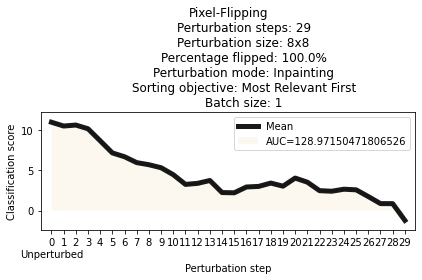

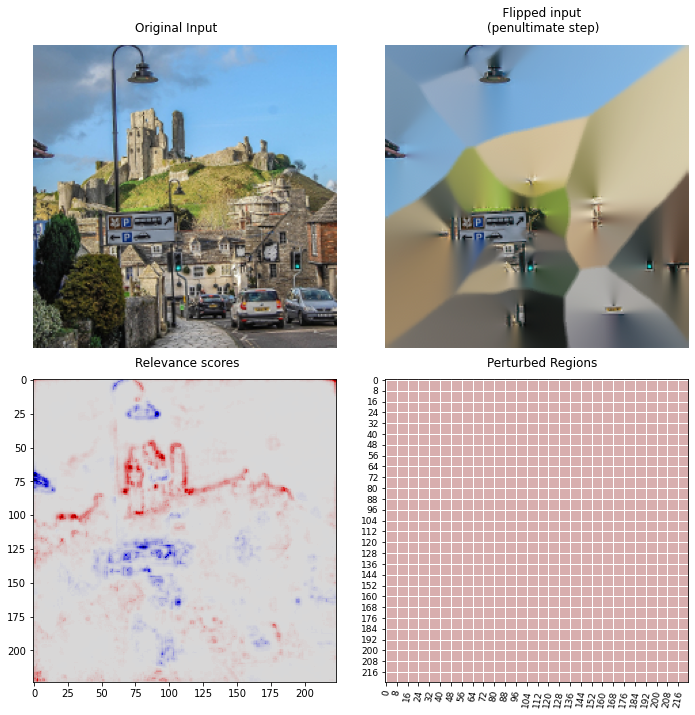

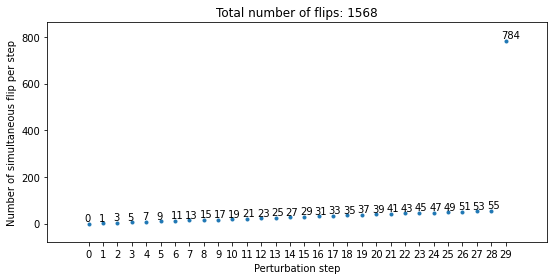

In [2]:
from pf.core import PixelFlipping
from pf.perturbation_modes.constants import PerturbModes
from typing import Callable

# Set parameters for the Pixel-Flipping algorithm
perturbation_steps: int = 29
perturbation_size: int = 8
perturb_mode: str = PerturbModes.INPAINTING  # or PerturbModes.RANDOM

# Create an instance of PixelFlipping
pixel_flipping_instance: PixelFlipping = PixelFlipping(
    perturbation_steps=perturbation_steps,
    perturbation_size=perturbation_size,
    perturb_mode=perturb_mode
)

# Clone the input and relevance scores
input_nchw: torch.Tensor = images.clone().detach()
relevance_scores_nchw: torch.Tensor = R.clone().detach()

# Function to return the classification score for the given input
# Adjust the index for CIFAR-10 classes (0 to 9)

# Example for class 'Cat' with index 3
class_index = 3  # Adjust this index based on the class you want to analyze


def forward_pass(input_nchw): 
    return model(input_nchw)[:, class_index] 


# Run the Pixel-Flipping algorithm
pixel_flipping_instance(input_nchw, relevance_scores_nchw, forward_pass)

# Plot the results
pixel_flipping_instance.plot_class_prediction_scores()
pixel_flipping_instance.plot_image_comparison()
pixel_flipping_instance.plot_number_of_flips_per_step()

## Region Perturbation

### Perturbation Mode: Random

Finished '_flip' in 0.1467 secs
Finished '_flip' in 0.1456 secs
Finished '_flip' in 0.1490 secs
Finished '_flip' in 0.1450 secs
Finished '_flip' in 0.1412 secs
Finished '_flip' in 0.1461 secs
Finished '_flip' in 0.1546 secs
Finished '_flip' in 0.1498 secs
Finished '_flip' in 0.1574 secs
Finished '_flip' in 0.1496 secs
Finished '_flip' in 0.1500 secs
Finished '_flip' in 0.1493 secs
Finished '_flip' in 0.1495 secs
Finished '_flip' in 0.1498 secs
Finished '_flip' in 0.1532 secs
Finished '_flip' in 0.1555 secs
Finished '_flip' in 0.1532 secs
Finished '_flip' in 0.1482 secs
Finished '_flip' in 0.1496 secs
Finished '_flip' in 0.1445 secs
Finished '_flip' in 0.1489 secs
Finished '_flip' in 0.1449 secs
Finished '_flip' in 0.1468 secs
Finished '_flip' in 0.1438 secs
Finished '_flip' in 0.1496 secs
Finished '_flip' in 0.1476 secs
Finished '_flip' in 0.1479 secs
Finished '_flip' in 0.1450 secs
Finished '_flip' in 0.1442 secs
Finished '__call__' in 4.4601 secs
Finished 'calculate_auc_score' in 0.0

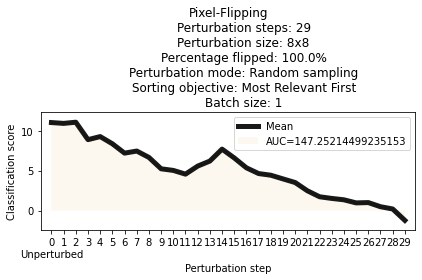

WARNING   Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


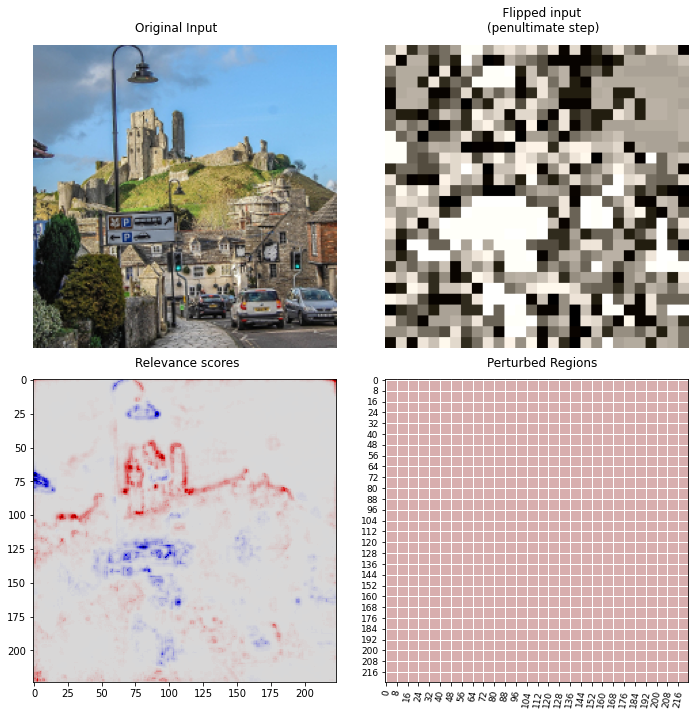

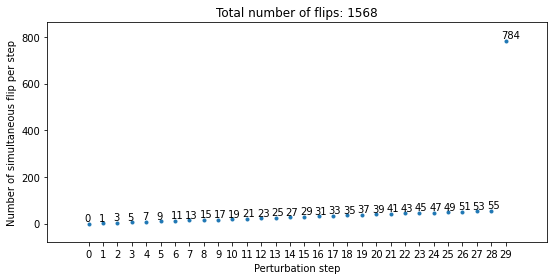

In [3]:
from pf.core import PixelFlipping
from pf.perturbation_modes.constants import PerturbModes
from typing import Callable

# Set parameters for the Pixel-Flipping algorithm
perturbation_steps: int = 29
perturbation_size: int = 8
perturb_mode: str = PerturbModes.RANDOM  # or PerturbModes.RANDOM

# Create an instance of PixelFlipping
pixel_flipping_instance: PixelFlipping = PixelFlipping(
    perturbation_steps=perturbation_steps,
    perturbation_size=perturbation_size,
    perturb_mode=perturb_mode
)

# Clone the input and relevance scores
input_nchw: torch.Tensor = images.clone().detach()
relevance_scores_nchw: torch.Tensor = R.clone().detach()

# Function to return the classification score for the given input
# Adjust the index for CIFAR-10 classes (0 to 9)

# Example for class 'Cat' with index 3
class_index = 3  # Adjust this index based on the class you want to analyze


def forward_pass(input_nchw): 
    return model(input_nchw)[:, class_index] 


# Run the Pixel-Flipping algorithm
pixel_flipping_instance(input_nchw, relevance_scores_nchw, forward_pass)

# Plot the results
pixel_flipping_instance.plot_class_prediction_scores()
pixel_flipping_instance.plot_image_comparison()
pixel_flipping_instance.plot_number_of_flips_per_step()